# Implementing tile overlap

In [205]:
import glob
import os
import enum
import re
import dask
import dask.array as da
from dask.array.core import normalize_chunks
import skimage
from skimage.io import imshow, imread
import numpy as np
from tqdm.auto import tqdm
import napari
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from skimage.transform import AffineTransform
from typing import Tuple, List, Dict, Union, Optional, Callable 
from pathlib import Path
from functools import partial
from scipy.ndimage import affine_transform

from shapely.geometry.base import BaseGeometry
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString
from shapely.strtree import STRtree

In [189]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0
    GFP = 1
    RFP = 2
    IRFP = 3
    MASK_2 = 97
    MASK_1 = 98
    MASK = 99

def parse_filename(filename: os.PathLike) -> dict:
    """Parse an OctopusHeavy filename and retreive metadata from the file.

    Parameters
    ----------
    filename : PathLike
        The full path to a file to parse.

    Returns
    -------
    metadata : dict
        A dictionary containing the parsed metadata.
    """
    
    OCTOPUSHEAVY_FILEPATTERN =(
        "r(?P<row>[0-9]+)c(?P<column>[0-9]+)f(?P<mosaic_pos>[0-9]+)p(?P<plane>[0-9]+)-ch(?P<channel>[0-9]+)"
        "sk(?P<time>[0-9]+)fk(?P<fk>[0-9]+)fl(?P<fl>[0-9]+)"
        )
    
    path, filename = os.path.split(filename)
    params = re.match(OCTOPUSHEAVY_FILEPATTERN, filename)

    filename_metadata = {
        "filename": filename,
        "channel": params.group("channel"),# Channels(int(params.group("channel"))),
        "time": params.group("time"),
        "row": params.group("row"), 
        "column": params.group("column"), 
        "mosaic_pos": params.group("mosaic_pos"), 
        "plane": params.group("plane"), 
        "fk": params.group("fk"), 
        "fl": params.group("fl")

    }

    return filename_metadata

def read_harmony_metadata(metadata_path: os.PathLike):
    """
    Read the metadata from the Harmony software for the Opera Phenix microscope.
    Takes an input of the path to the metadata .xml file.
    Returns the metadata in a pandas dataframe format.
    """
    
    ### read xml metadata file
    xml_data = open(metadata_fn, 'r').read()
    root = ET.XML(xml_data) 
    ### extract the metadata from the xml file
    images_metadata = [child for child in root if "Images" in child.tag][0]
    ### create an empty list for storing individual image metadata
    all_images_dicts = list()
    ### iterate over every image entry extracting the metadata
    for image_metadata in tqdm(images_metadata, total = len(images_metadata)):
        ### create empty dict to store single image metadata
        single_image_dict = dict()
        ### iterate over every metadata item in that image metadata
        for item in image_metadata:
            ### get column names from metadata
            col = item.tag.replace('{http://www.perkinelmer.com/PEHH/HarmonyV5}','')
            ### get metadata
            entry = item.text
            ### make dictionary out of metadata
            single_image_dict[col] = entry
        ### append that image metadata to list of all images    
        all_images_dicts.append(single_image_dict)
    ### create a dataframe out of all metadata
    df = pd.DataFrame(all_images_dicts)
    
    return df

In [201]:
def transform_tile_coord(shape: Tuple[int,int], affine_matrix: np.ndarray) -> np.ndarray:
    """
    returns the corner coordinates of a 2D array with shape shape
    after applying the transform represented by affine_matrix.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    h, w = shape
    # create homogeneous coordinates for corner points
    baserect = np.array([[0, 0], [h, 0], [h, w], [0, w]])
    augmented_baserect = np.concatenate(
        (baserect, np.ones((baserect.shape[0], 1))), axis=1
    )
    # see where the corner points map to
    transformed_rect = (affine_matrix @ augmented_baserect.T).T[:, :-1]
    return transformed_rect

def get_chunk_coord(shape: Tuple[int, int], chunk_size: Tuple[int, int]):
    """Iterator that returns the bounding coordinates
    for the individual chunks of a dask array of size
    shape with chunk size chunk_size.


    return_np_slice determines the output format. If True,
    a numpy slice object is returned for each chunk, that can be used
    directly to slice a dask array to return the desired chunk region.
    If False, a Tuple of Tuples ((row_min, row_max+1),(col_min, col_max+1))
    is returned.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)

    """
    chunksy, chunksx = normalize_chunks(chunk_size, shape=shape)
    y = 0
    for cy in chunksy:
        x = 0
        for cx in chunksx:
            yield ((y, y + cy), (x, x + cx))
            x = x + cx
        y = y + cy
        
def numpy_shape_to_shapely(coords: np.ndarray, shape_type: str = "polygon") -> BaseGeometry:
    """
    Convert an individual shape represented as a numpy array of coordinates
    to a shapely object
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    _coords = coords[:, ::-1].copy()  # shapely has col,row order, numpy row,col
    _coords[:, 1] *= -1  # axis direction flipped between shapely and napari
    if shape_type in ("rectangle", "polygon", "ellipse"):
        return Polygon(_coords)
    elif shape_type in ("line", "path"):
        return LineString(_coords)
    else:
        raise ValueError
        
def get_rect_from_chunk_boundary(chunk_boundary):
    """given a chunk boundary tuple, return a numpy
    array that can be added as a shape to napari"
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    ylim, xlim = chunk_boundary
    miny, maxy = ylim[0], ylim[1] - 1
    minx, maxx = xlim[0], xlim[1] - 1
    return np.array([[miny, minx], [maxy, minx], [maxy, maxx], [miny, maxx]])

def find_chunk_tile_intersections(
    tiles_shapely: List["shapely.geometry.base.BaseGeometry"],
    chunks_shapely: List["shapely.geometry.base.BaseGeometry"],
) -> Dict[Tuple[int, int], Tuple[str, np.ndarray]]:
    """
    For each output array chunk, find the intersecting image tiles

    Args:
        tile_shapes: Contains the shapely objects corresponding to transformed image outlines.
                    Each shape in tile_shapes must have a .fuse_info dictionary with
                    keys "file" and "transform".
        chunk_shapes: Contains the shapely objects representing dask array chunks.
                    Each shape in chunk_shapes must have a .fuse_info dictionary with
                    key "chunk_boundary", containing a tuple of chunk boundaries

    Returns:
         The chunk_to_tiles dictionary, which has the chunk anchor points as keys and tuples of
         image file names and their corresponding affine transform matrix as values.
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    chunk_to_tiles = {}
    tile_tree = STRtree(tiles_shapely)

    for chunk_shape in chunks_shapely:
        chunk_boundary = chunk_shape.fuse_info["chunk_boundary"]
        anchor_point = (chunk_boundary[0][0], chunk_boundary[1][0])
        intersecting_tiles = tile_tree.query(chunk_shape)
        chunk_to_tiles[anchor_point] = [
            ((t.fuse_info["file"], t.fuse_info["transform"]))
            for t in intersecting_tiles
        ]
    return chunk_to_tiles

def fuse_func(
    input_tile_info: Dict[
        Tuple[int, int], List[Tuple[Union[str, Path, np.ndarray], np.ndarray]]
    ],
    imload_fn: Optional[Callable] = imread,
    block_info=None,
    dtype=np.uint16,
) -> np.ndarray:

    """
    Fuses the tiles that intersect the current chunk of a dask array using maximum projection.

    Pass this function to dask.array.map_blocks, after partial evaluation of the required
    image_folder and (if needed) optional arguments.

    Returns:
        Array of chunk-shape containing max projection of tiles falling into chunk
        
    From DaskFusion (https://github.com/VolkerH/DaskFusion/)
    """
    array_location = block_info[None]["array-location"]
    # The anchor point is the key to the input_tile_info dictionary
    anchor_point = (array_location[0][0], array_location[1][0])
    chunk_shape = block_info[None]["chunk-shape"]
    tiles_info = input_tile_info[anchor_point]
    print(f"Processing chunk at {anchor_point}")
    fused = np.zeros(chunk_shape, dtype=dtype)
    for image_representation, tile_affine in tiles_info:
        if imload_fn is not None:
            # When imload_fn is provided we assume we have been given strings representing files
            tile_path = image_representation
            im = imload_fn(tile_path)
        else:
            # Without imload function we assume images are passed
            im = image_representation
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(
            im,
            matrix=np.linalg.inv(shift.params @ tile_affine),
            output_shape=chunk_shape,
            cval=0,
        )
        # note that the dtype comversion here happens without scaling
        # may want to use one of the skimage.img_as_* functions instead
        stack = np.stack([fused, tile_shifted.astype(dtype)])
        fused = np.max(stack, axis=0)
    return fused

FilePath = Union[Path, str]
ArrayLike = Union[
    np.ndarray, "dask.array.Array"
]  # could add other array types if needed

def load_image(
    file: FilePath, transforms: List[Callable[[ArrayLike], ArrayLike]] = None
) -> np.ndarray:
    img = imread(file)
    # if img.ndim == 2:
    #    img = np.expand_dims(img, axis=0)
    if transforms is not None:
        for t in transforms:
            img = t(img)
    return img

#### Find images

In [212]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
# image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/r03c03f01p01/'
fns = glob.glob(os.path.join(image_dir, '*.tiff'))
fns = glob.glob(os.path.join(image_dir, f'r0{row}c0{col}*.tiff'))
print(len(fns), 'image files found')

4050 image files found


### Loading metadata

In [82]:
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
df = read_harmony_metadata(metadata_fn)

  0%|          | 0/113400 [00:00<?, ?it/s]

#### Get position information from metadata

In [87]:
row_col_list = list()
for index, row in tqdm(df.iterrows(), total = len(df)):
    row_col_list.append(tuple((int(row['Row']), int(row['Col']))))
row_col_list = list(set(row_col_list))
for n, i in enumerate(row_col_list):
    print('Position index and (row,column):', n, i)

  0%|          | 0/113400 [00:00<?, ?it/s]

Position index and (row,column): 0 (3, 4)
Position index and (row,column): 1 (4, 3)
Position index and (row,column): 2 (4, 9)
Position index and (row,column): 3 (3, 7)
Position index and (row,column): 4 (5, 4)
Position index and (row,column): 5 (4, 6)
Position index and (row,column): 6 (3, 10)
Position index and (row,column): 7 (5, 7)
Position index and (row,column): 8 (6, 5)
Position index and (row,column): 9 (6, 8)
Position index and (row,column): 10 (4, 5)
Position index and (row,column): 11 (3, 3)
Position index and (row,column): 12 (3, 9)
Position index and (row,column): 13 (5, 6)
Position index and (row,column): 14 (4, 8)
Position index and (row,column): 15 (3, 6)
Position index and (row,column): 16 (5, 9)
Position index and (row,column): 17 (6, 4)
Position index and (row,column): 18 (6, 7)
Position index and (row,column): 19 (4, 7)
Position index and (row,column): 20 (3, 5)
Position index and (row,column): 21 (4, 4)
Position index and (row,column): 22 (4, 10)
Position index and 

### Select position

In [96]:
row, col = row_col_list[27]
fns = glob.glob(os.path.join(image_dir, f'r0{row}c0{col}*.tiff'))

#### Lazily load as dask array 

In [97]:
sample = skimage.io.imread(fns[0])
lazy_arrays = [dask.delayed(skimage.io.imread)(fn) for fn in fns]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)#'uint8')#
               for x in lazy_arrays]
print(len(lazy_arrays), 'images lazily loaded')

4050 images lazily loaded


# Extract metadata for tiling

Pull the XY coords, image resolution scale factors to convert the positional information into normalised pixel translations.

In [100]:
coords = df.loc[(df['Row'] == f'{row}') & (df['Col'] == f'{col}'), ("URL", "PositionX", "PositionY", "PositionZ", "ImageResolutionX", "ImageResolutionY")]
coords['PositionXPix'] = (coords['PositionX'].astype(float))/(coords['ImageResolutionX']).astype(float)
coords['PositionYPix'] = (coords['PositionY'].astype(float))/(coords['ImageResolutionY']).astype(float)
norm_coords = list(zip(coords['PositionXPix'], coords['PositionYPix']))

### Convert the tile coordinates into transformation matrices and apply to tiles

In [104]:
transforms = [AffineTransform(translation=stage_coord).params for stage_coord in norm_coords]
tiles = [transform_tile_coord(tile_shape, transform) for transform in transforms]

### Shift the tiles coordinates to the origin

Get the min/max coord info from all bounding boxes and calculate a single transformation matrix to apply, then apply it

In [136]:
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)
stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
shift_to_origin = AffineTransform(translation=-all_min)
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [transform_tile_coord(tile_shape, t) for t in transforms_with_shift]

### Decide on a chunk size to discretize the dask array into and normalise using dask

In [142]:
chunk_size = (6048/3,6048/3)
chunk_size

(2016.0, 2016.0)

In [143]:
chunks = normalize_chunks(chunk_size,shape=tuple(stitched_shape))
chunks

((2016, 2016, 2016), (2016, 2016, 2016))

### Check chunks sum to overall array shape

In [144]:
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)
computed_shape, stitched_shape

(array([6048, 6048]), (6048, 6048))

### Get the boundary coords of the chunks

In [151]:
chunk_boundaries = list(get_chunk_coord(stitched_shape, chunk_size))
chunk_boundaries

[((0, 2016), (0, 2016)),
 ((0, 2016), (2016, 4032)),
 ((0, 2016), (4032, 6048)),
 ((2016, 4032), (0, 2016)),
 ((2016, 4032), (2016, 4032)),
 ((2016, 4032), (4032, 6048)),
 ((4032, 6048), (0, 2016)),
 ((4032, 6048), (2016, 4032)),
 ((4032, 6048), (4032, 6048))]

### Now we use shapely to find the intersection of chunks and tiles

In [158]:
tiles_shapely = []#[numpy_shape_to_shapely(s) for s in tiles]

In [160]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]

In [162]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

### Couple the tile and chunk shape data with filenames and transformations

In [182]:
for tile_shifted_shapely, file, transform in zip(tiles_shifted_shapely, 
                                                 fns, 
                                                 transforms_with_shift):
    tile_shifted_shapely.fuse_info = {'file':file, 
                                      'transform':transform}
    

for chunk_shapely, chunk_boundary  in zip(chunks_shapely, 
                                          chunk_boundaries):
    chunk_shapely.fuse_info = {'chunk_boundary': chunk_boundary}
chunk_tiles = find_chunk_tile_intersections(tiles_shifted_shapely, chunks_shapely)

In [211]:
len(chunk_tiles[(0,0)])

1800

In [202]:
_load_image = partial(load_image, transforms=[])#input_transforms)

In [203]:
_fuse_func=partial(fuse_func, 
                   imload_fn=_load_image,
                   dtype=np.uint8)

target_array = da.map_blocks(func=_fuse_func,
                             chunks=chunks, 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint8)
target_array

dask.array<fuse_func, shape=(6048, 6048), dtype=uint8, chunksize=(2016, 2016), chunktype=numpy.ndarray>

# Do this for each individual image and then stitch together into a tczyx array?

Processing chunk at (0, 0)Processing chunk at (0, 2016)

Processing chunk at (2016, 0)Processing chunk at (2016, 2016)
Processing chunk at (0, 4032)
Processing chunk at (2016, 4032)

Processing chunk at (4032, 0)
Processing chunk at (4032, 2016)
Processing chunk at (4032, 4032)
Processing chunk at (0, 0)Processing chunk at (0, 2016)
Processing chunk at (0, 4032)

Processing chunk at (2016, 0)Processing chunk at (2016, 2016)

Processing chunk at (2016, 4032)
Processing chunk at (4032, 0)
Processing chunk at (4032, 2016)Processing chunk at (4032, 4032)

Processing chunk at (0, 0)Processing chunk at (0, 2016)Processing chunk at (2016, 0)
Processing chunk at (2016, 2016)


Processing chunk at (0, 4032)Processing chunk at (2016, 4032)

Processing chunk at (4032, 0)Processing chunk at (4032, 2016)

Processing chunk at (4032, 4032)
Processing chunk at (0, 0)Processing chunk at (0, 2016)
Processing chunk at (2016, 0)

Processing chunk at (2016, 2016)Processing chunk at (0, 4032)
Processing chu

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Processing chunk at (0, 0)Processing chunk at (0, 2016)Processing chunk at (0, 4032)


Processing chunk at (2016, 0)
Processing chunk at (2016, 2016)Processing chunk at (2016, 4032)

Processing chunk at (4032, 0)Processing chunk at (4032, 2016)
Processing chunk at (4032, 4032)

Processing chunk at (0, 0)Processing chunk at (0, 2016)

Processing chunk at (2016, 0)Processing chunk at (2016, 2016)
Processing chunk at (0, 4032)

Processing chunk at (2016, 4032)Processing chunk at (4032, 0)
Processing chunk at (4032, 2016)

Processing chunk at (4032, 4032)
Processing chunk at (0, 0)Processing chunk at (0, 2016)

Processing chunk at (2016, 0)Processing chunk at (2016, 2016)
Processing chunk at (4032, 4032)
Processing chunk at (0, 4032)

Processing chunk at (2016, 4032)Processing chunk at (4032, 0)

Processing chunk at (4032, 2016)


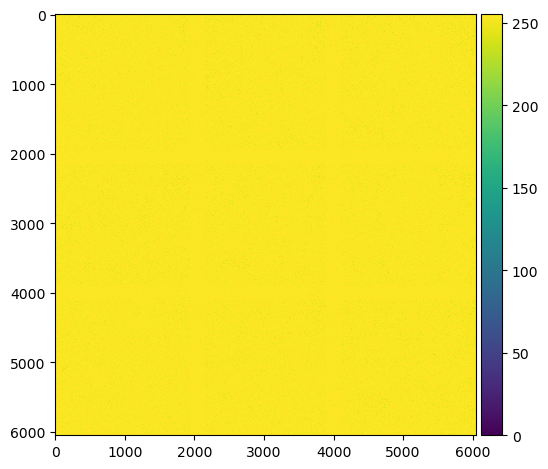

In [206]:
imshow(target_array)

In [208]:
target_array

dask.array<fuse_func, shape=(6048, 6048), dtype=uint8, chunksize=(2016, 2016), chunktype=numpy.ndarray>